# This example notebook on the usage of the lstchain_create_irf_files Tool, does the following:
## 1. Read the MC DL2 files of at least point-like gamma
## 2. Use a config file to apply the cuts and bin various parameters for the IRFs
## 3. Using pyirf functions, generate all the IRFs possible with the given inputs
## 4. Check some basic plots of the IRFs

To check the simple usage of the Tool, one can do the following in a terminal - 
$ lstchain_create_irf_files --help

For for more detailed help, 
$ lstchain_create_irf_files --help-all

The particles used for creating the IRFs currently are - 
* Point gamma (with 0.4 deg offset)
* Diffuse gamma
* Proton
* Electron

The MC files have discrete sky pointing direction, and hence, we need to specify the zenith and azimuth pointing, and have the MC files for the same sky direction pointing to create the IRFs.

We have been using Zenith 20 deg and Azimuth South pointing for the standard MC production with LST, but we also have few other direction pointing MC files to use.

The standard DL1/2 files are separated as *testing* and *training* files, where the DL1 *training* files are used to train the Random Forest model for the reconstruction of DL1 files to DL2, and DL2 *testing* files are used for producing the IRFs.

For cuts on gammaness and theta, one can use either fixed global cut or energy-dependent cut with fixed efficiency and containment region.

For the usage of the Tool, we also need a config file providing the event selection cuts and binning information. One can use the example config file available in `cta-lstchain/docs/examples/irf_tool_config.json` or create a similar config file for each specific use case. If the config file is not provided, the default values are used as per the Component in the file `cta-lstchain/lstchain/io/event_selection.py`.

In [1]:
%matplotlib inline
import numpy as np
from pathlib import Path

from astropy.io import fits
import astropy.units as u
from astropy.time import Time
from astropy.table import QTable, vstack

import matplotlib.pyplot as plt
from traitlets.config.loader import Config

In [2]:
from pyirf.io.gadf import (
    create_aeff2d_hdu,
    create_energy_dispersion_hdu,
    create_background_2d_hdu,
    create_psf_table_hdu,
    create_rad_max_hdu
)
from pyirf.irf import (
    effective_area_per_energy,
    energy_dispersion,
    effective_area_per_energy_and_fov,
    background_2d,
    psf_table,
)
from pyirf.spectral import (
    calculate_event_weights,
    PowerLaw,
    CRAB_MAGIC_JHEAP2015,
    IRFDOC_PROTON_SPECTRUM,
    IRFDOC_ELECTRON_SPECTRUM,
)
from pyirf.utils import calculate_source_fov_offset, calculate_theta

from gammapy.irf import EnergyDispersion2D, EffectiveAreaTable2D, Background2D, PSF3D

In [3]:
from lstchain.io.io import read_mc_dl2_to_QTable
from lstchain.io.event_selection import EventSelector, DL3Cuts, DataBinning
from lstchain.io.config import read_configuration_file
from lstchain.__init__ import __version__

# 1. Input parameters to convert MC DL2 files to IRF

In [4]:
# Using the standard MC files
mc_base_dir = "/fefs/aswg/data/mc/DL2/20200629_prod5_trans_80/"

# Using the same zenith, azimuth pointing and the production version to generate the IRF
mc_pnt_n_prod = "/zenith_20deg/south_pointing/20210923_v0.7.5_prod5_trans_80_dynamic_cleaning/"

# DL2 file paths for each particle
gamma_dl2 = mc_base_dir + "gamma" + mc_pnt_n_prod + "off0.4deg/dl2_gamma_20deg_180deg_off0.4deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5"
gamma_diffuse_dl2 = mc_base_dir + "gamma-diffuse" + mc_pnt_n_prod + "dl2_gamma-diffuse_20deg_180deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5"
proton_dl2 = mc_base_dir + "proton" + mc_pnt_n_prod + "dl2_proton_20deg_180deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5"
electron_dl2 = mc_base_dir + "electron" + mc_pnt_n_prod + "dl2_electron_20deg_180deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5"

output_irf_path = "/fefs/aswg/workspace/analysis-school-2022/src_indep/"

config_file = "../docs/examples/irf_tool_config.json"

# If Point-like IRFs are to be produced, value for point_like should be True, and
# for Full Enclosure IRFs, it should be False. 
# Accordingly, it will be beneficial to name the final output filename
output_irf_file = "pnt_irf_pnt_gamma_en_dep_soft_cuts.fits.gz"
point_like = True
overwrite = True
energy_dependent_gh_cuts = True
energy_dependent_theta_cuts = True

# 2. Collect the information of MC DL2 files

In [5]:
# Create a dict of information for the MC DL2 files of various particles
mc_particle = {
    "gamma": {
        "file": gamma_dl2, #gamma_diffuse_dl2
        "target_spectrum": CRAB_MAGIC_JHEAP2015,
    },
    "proton": {
        "file": proton_dl2,
        "target_spectrum": IRFDOC_PROTON_SPECTRUM,
    },
    "electron": {
        "file": electron_dl2,
        "target_spectrum": IRFDOC_ELECTRON_SPECTRUM,
    },
}


In [6]:
# Enter more details for each particle
for particle_type, p in mc_particle.items():
    p["events"], p["simulation_info"] = read_mc_dl2_to_QTable(p["file"])

    if p["simulation_info"].viewcone.value == 0.0:
        p["mc_type"] = "point_like"
    else:
        p["mc_type"] = "diffuse"

    # Calculating event weights for Background IRF
    if particle_type != "gamma":
        p["simulated_spectrum"] = PowerLaw.from_simulation(
            p["simulation_info"], 50 * u.hr
        )

        p["events"]["weight"] = calculate_event_weights(
            p["events"]["true_energy"],
            p["target_spectrum"],
            p["simulated_spectrum"],
        )
        
    # Calculate some offset columns
    for prefix in ("true", "reco"):
        k = f"{prefix}_source_fov_offset"
        p["events"][k] = calculate_source_fov_offset(p["events"], prefix=prefix)
        
        # calculate theta / distance between reco and assumed source position
        p["events"]["theta"] = calculate_theta(
            p["events"],
            assumed_source_az=p["events"]["true_az"],
            assumed_source_alt=p["events"]["true_alt"],
        )

# 3. Apply selection cuts and bin the events as per the config file

In [7]:
config = Config(read_configuration_file(config_file))
config

{'EventSelector': {'filters': {'intensity': [100, inf],
   'width': [0, inf],
   'length': [0, inf],
   'r': [0, 1],
   'wl': [0.1, 1],
   'leakage_intensity_width_2': [0, 0.2],
   'event_type': [32, 32]}},
 'DL3Cuts': {'global_gh_cut': 0.7,
  'gh_efficiency': 0.9,
  'global_theta_cut': 0.2,
  'theta_containment': 0.68,
  'allowed_tels': [1]},
 'DataBinning': {'true_energy_min': 0.01,
  'true_energy_max': 100,
  'true_energy_n_bins_per_decade': 5,
  'reco_energy_min': 0.01,
  'reco_energy_max': 100,
  'reco_energy_n_bins_per_decade': 5,
  'energy_migration_min': 0.2,
  'energy_migration_max': 5,
  'energy_migration_n_bins': 31,
  'fov_offset_min': 0.1,
  'fov_offset_max': 1.1,
  'fov_offset_n_edges': 9,
  'bkg_fov_offset_min': 0,
  'bkg_fov_offset_max': 10,
  'bkg_fov_offset_n_edges': 21,
  'source_offset_min': 0.0001,
  'source_offset_max': 1.0001,
  'source_offset_n_edges': 1000}}

In [8]:
gammas = mc_particle["gamma"]["events"]

background = vstack(
    [
        mc_particle["proton"]["events"],
        mc_particle["electron"]["events"]
    ]
)

In [9]:
data_bin = DataBinning(config=Config(config))
event_sel = EventSelector(config=Config(config))
cuts = DL3Cuts(config=Config(config))

In [10]:
# Binning of parameters used in IRFs
true_energy_bins = data_bin.true_energy_bins()
reco_energy_bins = data_bin.reco_energy_bins()
migration_bins = data_bin.energy_migration_bins()
source_offset_bins = data_bin.source_offset_bins()

mean_fov_offset = round(
    gammas["true_source_fov_offset"].mean().to_value(), 1
)

In [11]:
# For energy dependent cuts, one can check the cuts applied for both gammaness and theta with 2D histogram
if energy_dependent_gh_cuts or energy_dependent_theta_cuts:
    pre_cut_log_reco_gamma = gammas["log_reco_energy"].value
    pre_cut_theta_gamma = gammas["theta"].value
    pre_cut_gammaness_gamma = gammas["gh_score"].value

In [12]:
# Filter events

print("Size of the gamma table before the filter -",len(gammas))
print("Size of the background table before the filter -",len(background))

gammas = event_sel.filter_cut(gammas)
gammas = cuts.allowed_tels_filter(gammas)

background = cuts.allowed_tels_filter(background)
background = event_sel.filter_cut(background)

print("Size of the gamma table after the filter -", len(gammas))
print("Size of the background table after the filter -",len(background))

Size of the gamma table before the filter - 809721
Size of the background table before the filter - 1151208
Size of the gamma table after the filter - 452662
Size of the background table after the filter - 632356


In [13]:
# Apply the gammaness and theta cut

print("Size of the gamma table before the gammaness cut -",len(gammas))
print("Size of the background table before the gammaness cut -",len(background))

if energy_dependent_gh_cuts:
    gh_cuts_gamma = cuts.energy_dependent_gh_cuts(
        gammas, reco_energy_bins, 
        min_value=0.1, max_value=0.95
    )
    gammas = cuts.apply_energy_dependent_gh_cuts(
        gammas, gh_cuts_gamma
    )
    background = cuts.apply_energy_dependent_gh_cuts(
        background, gh_cuts_gamma
    )
else:
    gammas = cuts.apply_global_gh_cut(gammas)
    background = cuts.apply_global_gh_cut(background)

print("Size of the gamma table after the gammaness cut -",len(gammas))
print("Size of the background table after the gammaness cut -",len(background))

if point_like:
    if energy_dependent_theta_cuts:
        theta_cuts = cuts.energy_dependent_theta_cuts(
            gammas, reco_energy_bins,
            min_value=0.05 * u.deg, max_value=0.32 * u.deg,
        )
        gammas = cuts.apply_energy_dependent_theta_cuts(
            gammas, theta_cuts
        )
    else:
        gammas = cuts.apply_global_theta_cut(gammas)
    print("Size of the gamma table after the theta cut -",len(gammas))

Size of the gamma table before the gammaness cut - 452662
Size of the background table before the gammaness cut - 632356
Size of the gamma table after the gammaness cut - 403912
Size of the background table after the gammaness cut - 401151
Size of the gamma table after the theta cut - 204848


In [14]:
if energy_dependent_gh_cuts or energy_dependent_theta_cuts:
    post_cut_log_reco_gamma = gammas["log_reco_energy"].value
    post_cut_theta_gamma = gammas["theta"].value
    post_cut_gammaness_gamma = gammas["gh_score"].value

Text(0, 0.5, 'Gammaness')

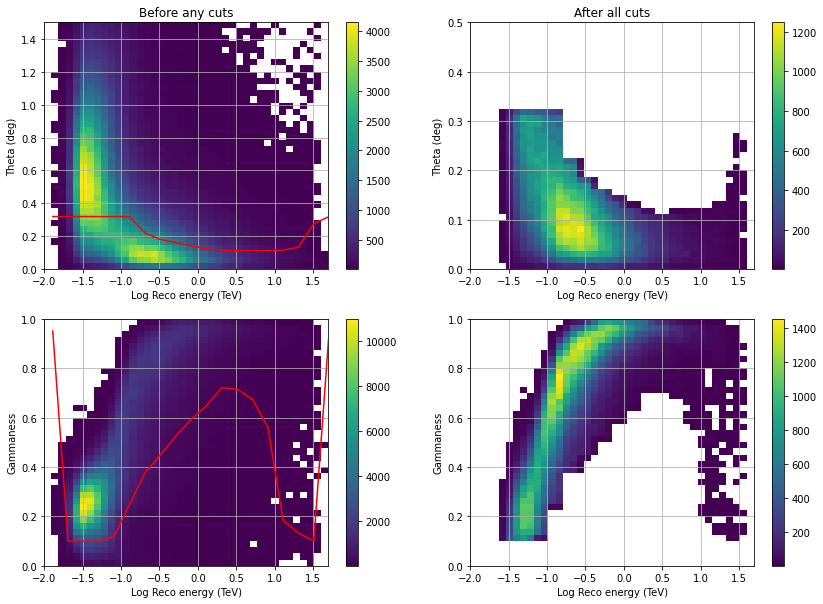

In [15]:
plt.figure(figsize=(14,10))

plt.subplot(221)
plt.hist2d(
    pre_cut_log_reco_gamma, pre_cut_theta_gamma, 
    bins=(40,40), cmin=1, range=[[-2,1.7],[0,1.5]]
)
plt.plot(
    np.log10(theta_cuts["center"].value), theta_cuts["cut"].value,
    color='r'
)

plt.colorbar()
plt.grid()
plt.xlabel("Log Reco energy (TeV)")
plt.ylabel("Theta (deg)")
plt.title("Before any cuts")

plt.subplot(222)
plt.hist2d(
    post_cut_log_reco_gamma, post_cut_theta_gamma, 
    bins=(40,40), cmin=1, range=[[-2,1.7],[0,0.5]]
)
plt.colorbar()
plt.grid()
plt.xlabel("Log Reco energy (TeV)")
plt.ylabel("Theta (deg)")
plt.title("After all cuts")

plt.subplot(223)
plt.hist2d(
    pre_cut_log_reco_gamma, pre_cut_gammaness_gamma, 
    bins=(40,40), cmin=1, range=[[-2,1.7],[0,1]]
)
plt.plot(
    np.log10(gh_cuts_gamma["center"].value), gh_cuts_gamma["cut"],
    color='r'
)

plt.colorbar()
plt.grid()
plt.xlabel("Log Reco energy (TeV)")
plt.ylabel("Gammaness")

plt.subplot(224)
plt.hist2d(
    post_cut_log_reco_gamma, post_cut_gammaness_gamma, 
    bins=(40,40), cmin=1, range=[[-2,1.7],[0,1]]
)

plt.colorbar()
plt.grid()
plt.xlabel("Log Reco energy (TeV)")
plt.ylabel("Gammaness")

In [16]:
# Get the FoV Offset bins as per the IRF type
if mc_particle["gamma"]["mc_type"] == "point_like":
    mean_fov_offset = round(
        gammas["true_source_fov_offset"].mean().to_value(), 1
    )
    fov_offset_bins = [
        mean_fov_offset - 0.1, mean_fov_offset + 0.1
    ] * u.deg
else:
    fov_offset_bins = data_bin.fov_offset_bins()
    # Using the full camera FoV as a single bin for diffue gamma MC, to create RAD_MAX HDU
    if energy_dependent_theta_cuts:
        fov_offset_bins = [
            round(
                gammas["true_source_fov_offset"].min().to_value(), 1
            ),
            round(
                gammas["true_source_fov_offset"].max().to_value(), 1
            )
        ] * u.deg            

background_offset_bins = data_bin.bkg_fov_offset_bins()

# 4. Get the extra header values for the final HDUs

In [17]:
extra_headers = {
    "TELESCOP": "CTA-N",
    "INSTRUME": "LST-" + " ".join(map(str, cuts.allowed_tels)),
    "FOVALIGN": "RADEC",
}

if not energy_dependent_gh_cuts:
    extra_headers["GH_CUT"] = cuts.global_gh_cut
    
    if point_like and not energy_dependent_theta_cuts:
        extra_headers["RAD_MAX"] = (
            cuts.global_theta_cut,
            'deg'
        )
else:
    extra_headers["GH_EFF"] = (
        cuts.gh_efficiency,
        "Gamma/hadron efficiency"
    )
    if point_like and energy_dependent_theta_cuts:
        extra_headers["TH_CONT"] = (
            cuts.theta_containment,
            "Theta containment region in percentage"
        )

# 5. Write the HDUs and enter it to the HDUList

In [18]:
hdus = [fits.PrimaryHDU(), ]

In [19]:
# Effective Area IRF, based on gamma MC type
with np.errstate(invalid="ignore", divide="ignore"):
    if mc_particle["gamma"]["mc_type"] == "point_like":
        effective_area = effective_area_per_energy(
            gammas,
            mc_particle["gamma"]["simulation_info"],
            true_energy_bins=true_energy_bins,
        )
        hdus.append(
            create_aeff2d_hdu(
                # add one dimension for single FOV offset
                effective_area=effective_area[..., np.newaxis],
                true_energy_bins=true_energy_bins,
                fov_offset_bins=fov_offset_bins,
                point_like=point_like,
                extname="EFFECTIVE AREA",
                **extra_headers,
            )
        )
    else:
        effective_area = effective_area_per_energy_and_fov(
            gammas,
            mc_particle["gamma"]["simulation_info"],
            true_energy_bins=true_energy_bins,
            fov_offset_bins=fov_offset_bins,
        )
        hdus.append(
            create_aeff2d_hdu(
                effective_area=effective_area,
                true_energy_bins=true_energy_bins,
                fov_offset_bins=fov_offset_bins,
                point_like=point_like,
                extname="EFFECTIVE AREA",
                **extra_headers,
            )
        )

In [20]:
# Energy Dispersion IRF
edisp = energy_dispersion(
    gammas,
    true_energy_bins=true_energy_bins,
    fov_offset_bins=fov_offset_bins,
    migration_bins=migration_bins,
)
hdus.append(
    create_energy_dispersion_hdu(
        edisp,
        true_energy_bins=true_energy_bins,
        migration_bins=migration_bins,
        fov_offset_bins=fov_offset_bins,
        point_like=point_like,
        extname="ENERGY DISPERSION",
        **extra_headers,
    )
)

In [21]:
# Background IRF
background = background_2d(
    background,
    reco_energy_bins=reco_energy_bins,
    fov_offset_bins=background_offset_bins,
    t_obs=50*u.hr,
)
hdus.append(
    create_background_2d_hdu(
        background.T,
        reco_energy_bins=reco_energy_bins,
        fov_offset_bins=background_offset_bins,
        extname="BACKGROUND",
        **extra_headers,
    )
)

In [22]:
# PSF Table IRF if point-like IRF
if not point_like:
    psf = psf_table(
        gammas,
        true_energy_bins,
        fov_offset_bins=fov_offset_bins,
        source_offset_bins=source_offset_bins,
    )
    hdus.append(
        create_psf_table_hdu(
            psf,
            true_energy_bins=true_energy_bins,
            source_offset_bins=source_offset_bins,
            fov_offset_bins=fov_offset_bins,
            extname="PSF",
            **extra_headers,
        )
    )

In [23]:
# GH CUTS HDU for energy-dependent cuts
if energy_dependent_gh_cuts:
    gh_header = fits.Header()
    gh_header["CREATOR"] = f"lstchain v{__version__}"
    gh_header["DATE"] = Time.now().utc.iso

    for k, v in extra_headers.items():
        gh_header[k] = v
        
    hdus.append(
        fits.BinTableHDU(
            gh_cuts_gamma, header=gh_header, name="GH_CUTS"
        )
    )

In [24]:
# RAD_MAX HDU for energy-dependent cuts for point-like
if energy_dependent_theta_cuts and point_like:
    hdus.append(
        create_rad_max_hdu(
            theta_cuts["cut"][:, np.newaxis],
            reco_energy_bins, fov_offset_bins,
            **extra_headers
        )
    )

# 6. Write the HDUList to the final IRF file

In [25]:
fits.HDUList(hdus).writeto(
    output_irf_path + output_irf_file, overwrite=overwrite
)

# 7. Check the IRFs with some basic plots with gammapy

In [26]:
aeff_plot = EffectiveAreaTable2D.read(output_irf_path + output_irf_file, hdu="EFFECTIVE AREA")
edisp_plot = EnergyDispersion2D.read(output_irf_path + output_irf_file, hdu="ENERGY DISPERSION")
bkg_plot = Background2D.read(output_irf_path + output_irf_file, hdu="BACKGROUND")

if not point_like:
    psf_plot = PSF3D.read(output_irf_path + output_irf_file, hdu="PSF")

Text(0.5, 1.0, 'Effective Area')

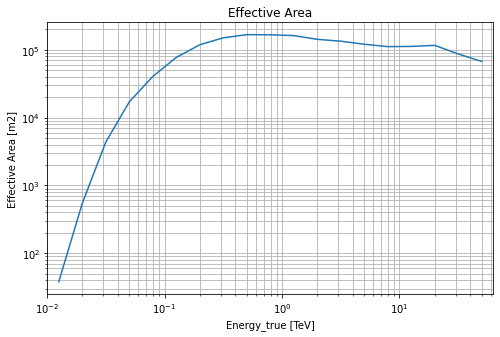

In [27]:
# Effective Area energy dependence
plt.figure(figsize=(8,5))

aeff_plot.plot_energy_dependence(offset=[0.4 * u.deg])
plt.legend().remove()
plt.yscale('log')
plt.grid(which='both')
plt.title("Effective Area")

Text(0.5, 1.0, 'Effective Area - energy offset dependence')

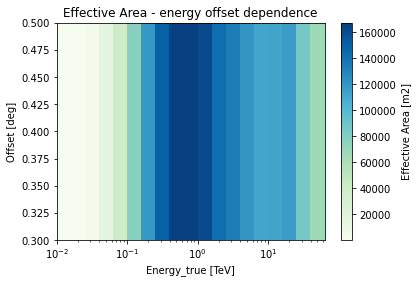

In [28]:
# Energy Offset dependence
aeff_plot.plot()
plt.title("Effective Area - energy offset dependence")

In [29]:
# Effective Area offset dependence when diffuse gamma is used
if not mc_particle["gamma"]["mc_type"] == "point_like":
    aeff_plot.plot_offset_dependence()

Text(0.5, 0.98, 'Energy migration')

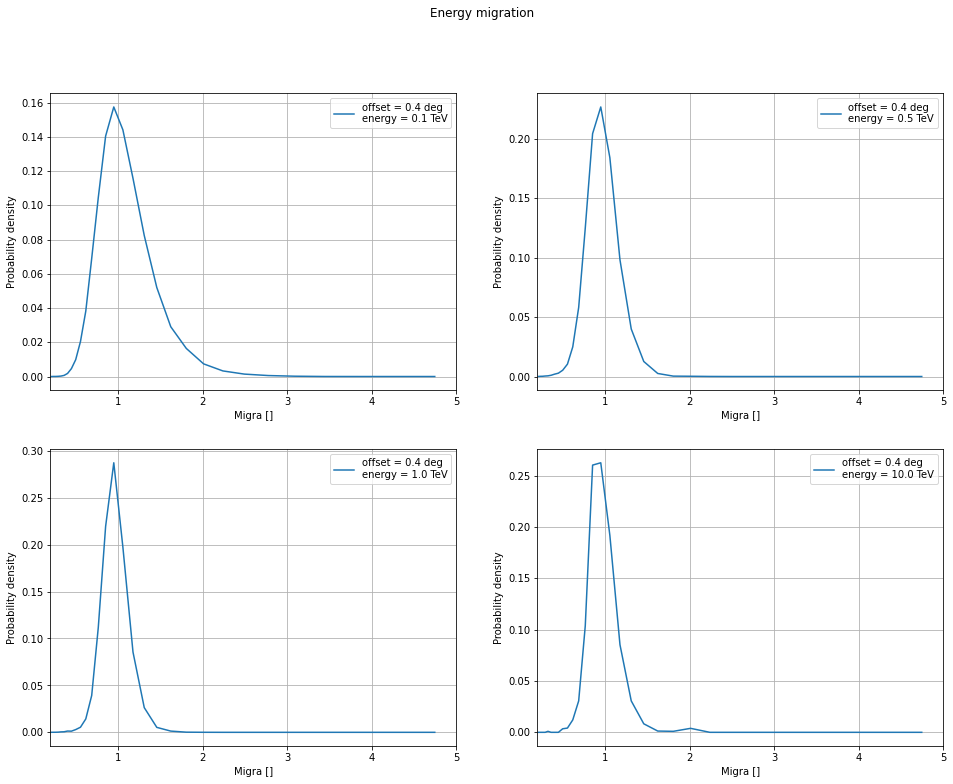

In [30]:
# Energy Dispersion, energy migratoin
plt.figure(figsize=(16,12))

offset = "0.4 deg"
true_energy = [0.1, 0.5, 1, 10] * u.TeV

plt.subplot(221)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[0])
plt.legend(loc=1)
plt.grid()

plt.subplot(222)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[1])
plt.legend(loc=1)
plt.grid()

plt.subplot(223)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[2])
plt.legend(loc=1)
plt.grid()

plt.subplot(224)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[3])
plt.legend(loc=1)
plt.grid()

plt.suptitle("Energy migration")

Text(0.5, 1.0, 'Energy Bias at 0.4 deg')

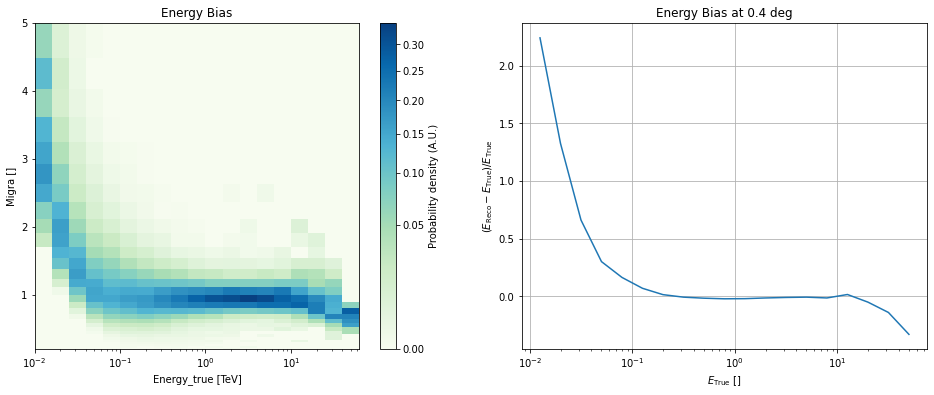

In [31]:
# Energy bias

plt.figure(figsize=(16,6))

plt.subplot(121)
edisp_plot.plot_bias(offset=offset, add_cbar=True)
plt.title("Energy Bias")

plt.subplot(122)
edisp_kernel = edisp_plot.to_edisp_kernel(offset=0.4*u.deg)
edisp_kernel.plot_bias()
plt.grid()
plt.title("Energy Bias at 0.4 deg")

Text(0.5, 1.0, 'Energy Migration Matrix')

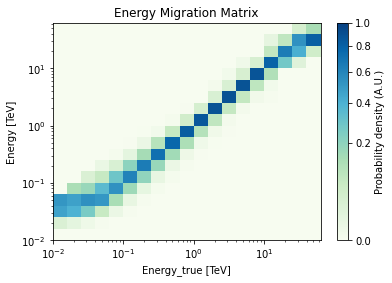

In [32]:
# Energy migration matrix
edisp_kernel.plot_matrix(add_cbar=True)
plt.title("Energy Migration Matrix")

Text(0.5, 1.0, 'Background rate - offset dependence')

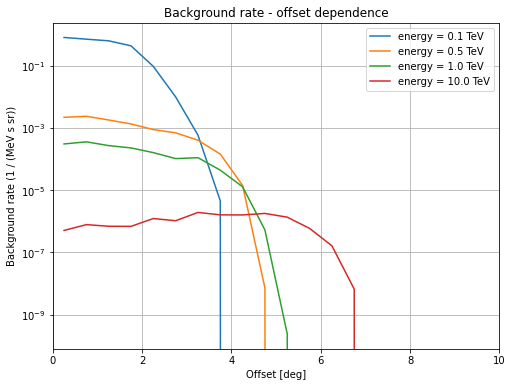

In [33]:
# Background, offset dependence
plt.figure(figsize=(8,6))

bkg_plot.plot_offset_dependence(energy=true_energy)
plt.grid(which="both")
plt.title("Background rate - offset dependence")

Text(0.5, 0.98, 'Background rate - energy dependence')

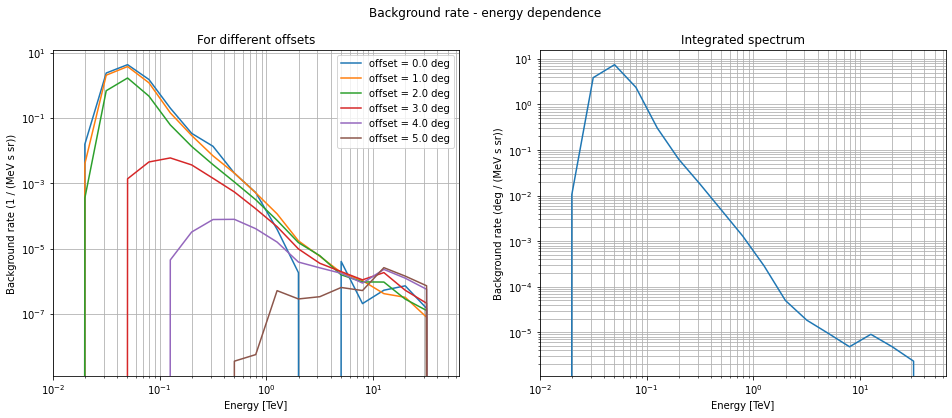

In [34]:
# Background rate energy dependence
plt.figure(figsize=(16,6))
bkg_offset = [0, 1, 2, 3, 4, 5] * u.deg

plt.subplot(121)

labels = []
for o in bkg_offset:
    bkg_plot.plot_energy_dependence(offset=[o])
    labels.append(f"offset = {o}")
plt.legend().remove()
plt.legend(labels)
plt.grid(which="both")
plt.title("For different offsets")

plt.subplot(122)
bkg_plot.plot_spectrum()
plt.grid(which="both")
plt.legend().remove()
plt.title("Integrated spectrum")

plt.suptitle("Background rate - energy dependence")

Text(0.5, 1.0, 'Background rate - energy offset dependence')

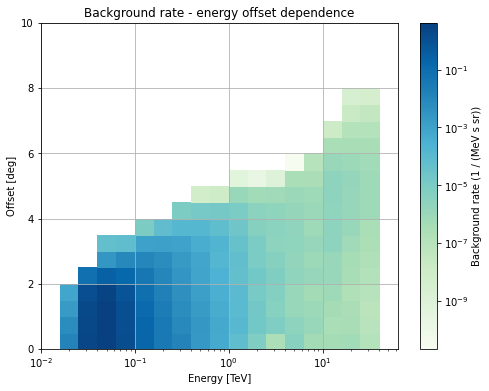

In [35]:
# Energy offset dependence
plt.figure(figsize=(8,6))
bkg_plot.plot()
plt.grid()
plt.title("Background rate - energy offset dependence")

In [36]:
if not point_like:
    psf_plot.peek()